In [188]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import seaborn as sns
from practicum_utils import get_loggi_files, global_connect, run_query, explained_time, careful_query

In [189]:
db = global_connect()

In [190]:
# Most available active user in database

In [191]:
df = careful_query("""
select d.*
from
(select driver_id,
    count(1) as pushes,
    sum(case when EXTRACT(DOW from sent_f) = 0 then 1 else 0 end) as d0,
    sum(case when EXTRACT(DOW from sent_f) = 1 then 1 else 0 end) as d1,    
    sum(case when EXTRACT(DOW from sent_f) = 2 then 1 else 0 end) as d2,
    sum(case when EXTRACT(DOW from sent_f) = 3 then 1 else 0 end) as d3,
    sum(case when EXTRACT(DOW from sent_f) = 4 then 1 else 0 end) as d4,
    sum(case when EXTRACT(DOW from sent_f) = 5 then 1 else 0 end) as d5,
    sum(case when EXTRACT(DOW from sent_f) = 6 then 1 else 0 end) as d6    
from availability a
group by driver_id
having count(1) >= 1000
) d""", 2000000)

In [192]:
df.shape

(7094, 9)

In [193]:
df.describe()

,pushes,d0,d1,d2,d3,d4,d5,d6
count,7094.000000,7094.000000,7094.000000,7094.000000,7094.000000,7094.000000,7094.000000,7094.00000
mean,4333.635326,204.091909,689.556104,722.531012,759.712010,837.259233,782.862278,337.62278
std,3628.612359,427.561973,590.734149,585.473598,603.849729,652.816541,620.632401,506.57345
min,1000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,1809.000000,0.000000,266.000000,300.000000,319.000000,349.000000,325.000000,53.00000
50%,3295.000000,48.000000,518.000000,561.500000,587.000000,659.000000,616.000000,174.50000
75%,5707.750000,212.000000,949.000000,987.000000,1036.000000,1152.000000,1067.750000,400.75000
max,44108.000000,6013.000000,6362.000000,6323.000000,6469.000000,6432.000000,6297.000000,6212.00000


### Drivers that never were connected in the whole period

In [194]:
dow = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
for i in range(7):
    print('{}: {:0.2f}%'.format(dow[i], df[df[f"d{i}"] == 0].shape[0]*100 / df.shape[0]))

Sunday: 25.33%
Monday: 0.10%
Tuesday: 0.03%
Wednesday: 0.11%
Thursday: 0.06%
Friday: 0.03%
Saturday: 7.43%


In [195]:
columns = [f"d{i}" for i in range(7)]
columns

['d0', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6']

In [196]:
df.iloc[0][columns].sum(), df.iloc[0].pushes

(5406, 5406)

In [197]:
for i in range(5):
    for j in range(i+1, 6):
        for k in range(j+1, 7):
            d1 = columns[i]
            d2 = columns[j]
            d3 = columns[k]
            cond = ((df[d1] + df[d2] + df[d3]) / df.pushes) > 0.6
            print(d1, d2, d3, df[cond].shape)

d0 d1 d2 (12, 9)
d0 d1 d3 (11, 9)
d0 d1 d4 (13, 9)
d0 d1 d5 (16, 9)
d0 d1 d6 (54, 9)
d0 d2 d3 (17, 9)
d0 d2 d4 (16, 9)
d0 d2 d5 (20, 9)
d0 d2 d6 (38, 9)
d0 d3 d4 (41, 9)
d0 d3 d5 (24, 9)
d0 d3 d6 (53, 9)
d0 d4 d5 (60, 9)
d0 d4 d6 (74, 9)
d0 d5 d6 (102, 9)
d1 d2 d3 (689, 9)
d1 d2 d4 (1252, 9)
d1 d2 d5 (563, 9)
d1 d2 d6 (24, 9)
d1 d3 d4 (1487, 9)
d1 d3 d5 (710, 9)
d1 d3 d6 (32, 9)
d1 d4 d5 (1508, 9)
d1 d4 d6 (40, 9)
d1 d5 d6 (59, 9)
d2 d3 d4 (1893, 9)
d2 d3 d5 (1071, 9)
d2 d3 d6 (38, 9)
d2 d4 d5 (1881, 9)
d2 d4 d6 (37, 9)
d2 d5 d6 (48, 9)
d3 d4 d5 (2309, 9)
d3 d4 d6 (84, 9)
d3 d5 d6 (82, 9)
d4 d5 d6 (151, 9)


In [222]:
dow = ['Sun','Mon','Tue','Wed','Thu','Fri','Sat']
ren = {columns[i]: dow[i] for i in range(7)}

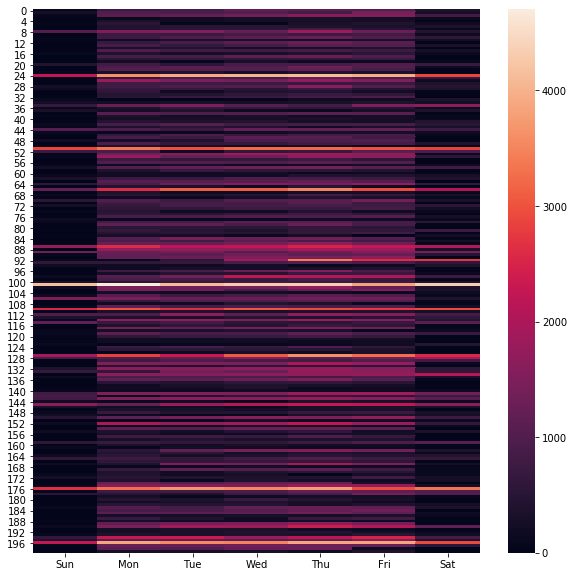

In [224]:
plt.figure(figsize=(10,10))
sns.heatmap(df.iloc[0:200][columns].rename(columns=ren));

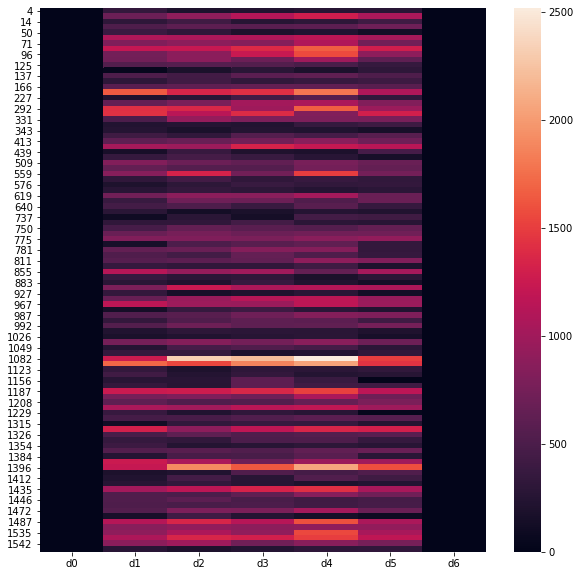

In [199]:
plt.figure(figsize=(10,10))
sns.heatmap(df.iloc[df.sort_values(by=['d0','d6']).index[0:100]][columns]);

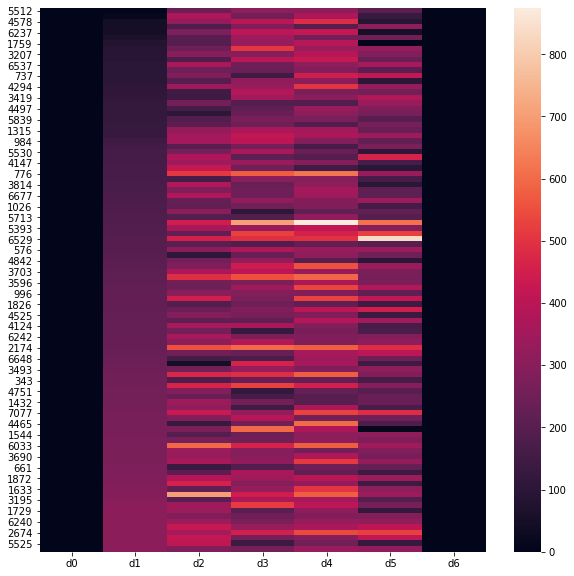

In [200]:
plt.figure(figsize=(10,10))
sns.heatmap(df.iloc[df.sort_values(by=['d0','d6','d1','d3','d5']).index[0:100]][columns]);

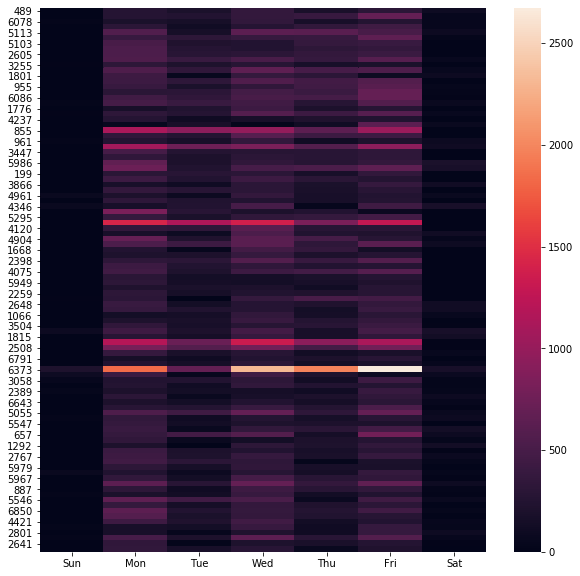

In [225]:
df['mon_wed_fri'] = (df['d1'] + df['d3'] + df['d5']) / df.pushes
df['tue_thu'] = (df['d2'] + df['d4']) / df.pushes
plt.figure(figsize=(10,10))
sns.heatmap(df.iloc[df.sort_values(by='mon_wed_fri').index[-100:]][columns].rename(columns=ren));

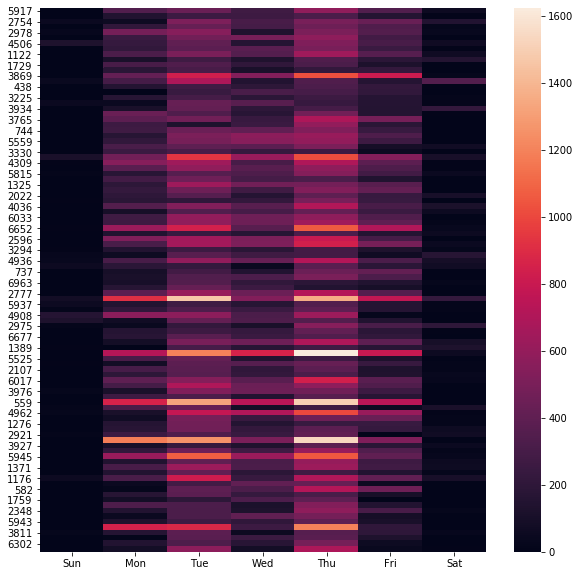

In [226]:
plt.figure(figsize=(10,10))
sns.heatmap(df.iloc[df.sort_values(by='tue_thu').index[-100:]][columns].rename(columns=ren));

In [203]:
dfr = df.copy()
for col in columns:
    dfr[col] /= dfr.pushes

dfr['mon_wed_fri'] = dfr['d1'] + dfr['d3'] + dfr['d5']
dfr['tue_thu'] = dfr['d2'] + dfr['d4']
dfr['sat_sun'] = dfr['d0'] + dfr['d6']
dfr.head()

,driver_id,pushes,d0,d1,d2,d3,d4,d5,d6,mon_wed_fri,tue_thu,sat_sun
0,0008ee0d78b18c923c3db217e130e92c,5406,0.015908,0.142249,0.160007,0.215871,0.209582,0.190344,0.066038,0.548465,0.369589,0.081946
1,001630e33484a3f04b99133f743ef961,5736,0.047420,0.171897,0.160739,0.177476,0.150105,0.242329,0.050035,0.591702,0.310844,0.097455
2,001a3db70a4022a2f375441a9fc8960a,7691,0.010532,0.143154,0.154336,0.175790,0.209726,0.199844,0.106618,0.518788,0.364062,0.117150
3,003238f3e0623d554e28db105c6b9a78,1271,0.031471,0.087333,0.153423,0.189614,0.243902,0.182533,0.111723,0.459481,0.397325,0.143194
4,004417983b10e30f5510cd867d6f3439,1301,0.000000,0.262106,0.157571,0.171407,0.200615,0.208301,0.000000,0.641814,0.358186,0.000000


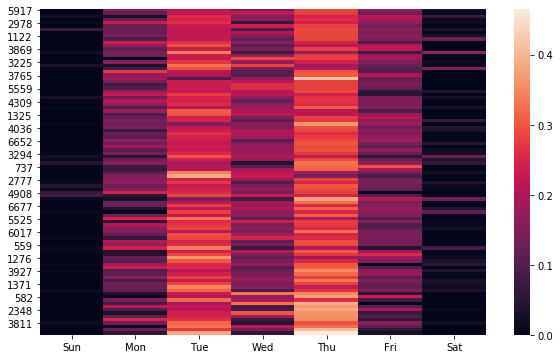

In [227]:
plt.figure(figsize=(10,6))
sns.heatmap(dfr.iloc[dfr.sort_values(by='tue_thu').index[-100:]][columns].rename(columns=ren));

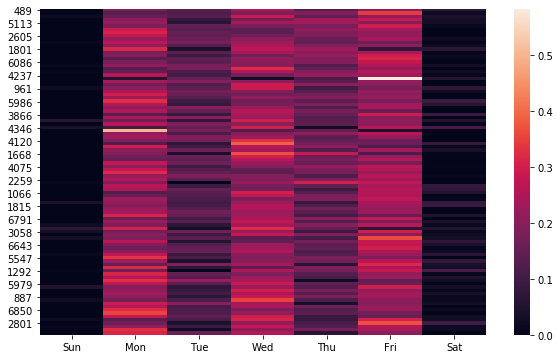

In [228]:
plt.figure(figsize=(10,6))
sns.heatmap(dfr.iloc[dfr.sort_values(by='mon_wed_fri').index[-100:]][columns].rename(columns=ren));

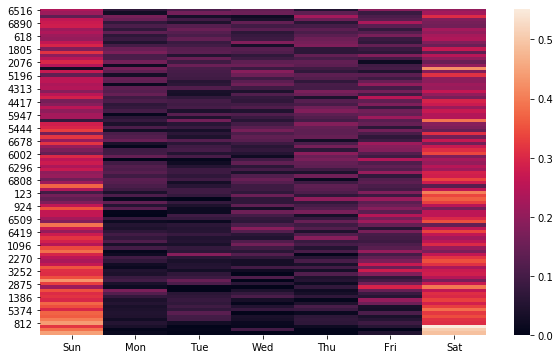

In [229]:
plt.figure(figsize=(10,6))
sns.heatmap(dfr.iloc[dfr.sort_values(by='sat_sun').index[-100:]][columns].rename(columns=ren));

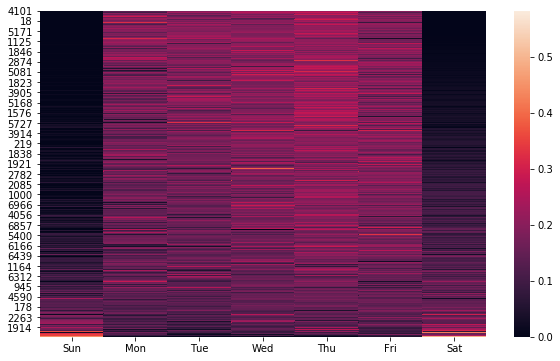

In [230]:
plt.figure(figsize=(10,6))
sns.heatmap(dfr.iloc[dfr.sort_values(by='sat_sun').index[100:]][columns].rename(columns=ren));

In [208]:
dfa = careful_query("""
select 
    extract(dow from sent_f) as dow,
    extract(hour from sent_f) as hour,
    count(1) as pushes
from availability a
group by extract(dow from sent_f), extract(hour from sent_f)
""", 1000000)

dfa = dfa.astype('int')

In [209]:
dfa

,dow,hour,pushes
0,0,0,37467
1,0,1,26132
2,0,2,21138
3,0,3,18694
4,0,4,17860
...,...,...,...
163,6,19,136273
164,6,20,123025
165,6,21,106845
166,6,22,88398


In [210]:
rcol = {i: d for i, d in enumerate(dow)}
dft = dfa.copy()
dft.pushes = dft.pushes.astype('float')
dft.pushes = np.log(dft.pushes)

In [211]:
dft = dft.pivot_table(values='pushes', index=dft.dow, columns='hour', aggfunc='first').rename(rcol)

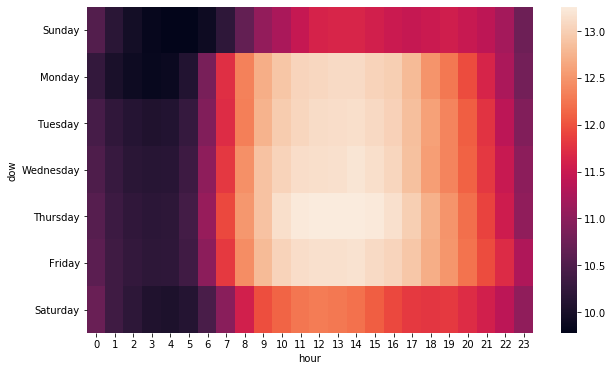

In [212]:
plt.figure(figsize=(10,6))
sns.heatmap(dft);

In [213]:
dfr[columns]

,d0,d1,d2,d3,d4,d5,d6
0,0.015908,0.142249,0.160007,0.215871,0.209582,0.190344,0.066038
1,0.047420,0.171897,0.160739,0.177476,0.150105,0.242329,0.050035
2,0.010532,0.143154,0.154336,0.175790,0.209726,0.199844,0.106618
3,0.031471,0.087333,0.153423,0.189614,0.243902,0.182533,0.111723
4,0.000000,0.262106,0.157571,0.171407,0.200615,0.208301,0.000000
...,...,...,...,...,...,...,...
7089,0.031616,0.116380,0.151481,0.173513,0.206373,0.209360,0.111277
7090,0.036098,0.134938,0.155135,0.165019,0.196820,0.225183,0.086807
7091,0.035668,0.164274,0.168914,0.242424,0.185588,0.172539,0.030593
7092,0.014503,0.281363,0.148658,0.127629,0.163162,0.210297,0.054387


In [214]:
from sklearn.cluster import KMeans

In [237]:
def show_kind_of_drivers(n_clusters=2):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(dfr[columns])
    print(np.bincount(kmeans.labels_) / len(dfr))
    sns.heatmap(pd.DataFrame(data=kmeans.cluster_centers_, columns=dow, index=[f"class {i}" for i in range(n_clusters)]))
    plt.show()


[0.68494502 0.31505498]


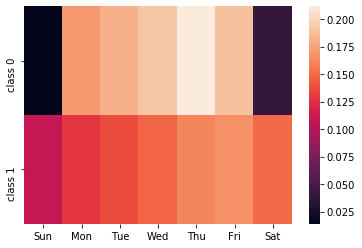

In [238]:
show_kind_of_drivers(2)

**2 classes**
- class 0: drivers who work from monday to friday
- class 1: those who work the entire week

[0.54186637 0.32576825 0.13236538]


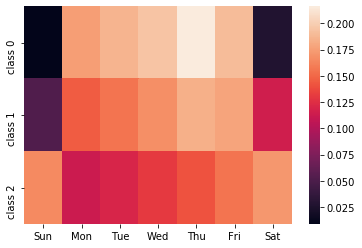

In [239]:
show_kind_of_drivers(3)

**3 classes**
- class 0: works from monday to friday
- class 1: works from monday to friday and half of the saturday
- class 2: works the entire week with more weights on weekends

[0.38736961 0.28474767 0.12263885 0.20524387]


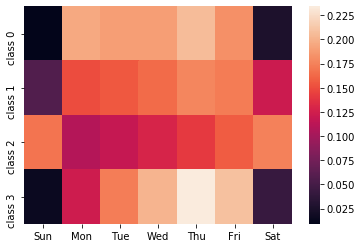

In [240]:
show_kind_of_drivers(4)

**4 classes**
- class 0: monday to friday
- class 1: monday to friday and half of the saturday
- class 2: work on weekends. But from monday to sunday the activity goes up
- class 3: light work on monday and tuesday and heavy work on wednesday, thursday and friday


[0.17705103 0.18776431 0.33704539 0.23893431 0.05920496]


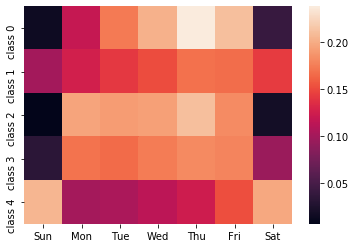

In [241]:
show_kind_of_drivers(5)

**5 classes**
- class 0: light work on monday and tuesday and heavy work on wednesday, thursday and friday
- class 1: work the entire week
- class 2: work from monday to friday
- class 3: work from monday to friday and half of the saturday
- class 4: work on weekends

[0.10797857 0.03073019 0.0720327  0.1082605  0.06695799 0.06484353
 0.04581336 0.17578235 0.08908937 0.23851142]


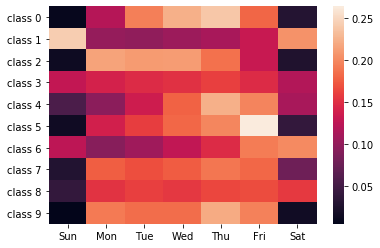

In [242]:
show_kind_of_drivers(10)

**10 classes**
- class 0 (11%): monday to friday with intensity on thursdays
- class 1 ( 3%): weekends
- class 2 ( 7%): monday to friday with intensity from monday to wednesday
- class 3 (11%): entire week
- class 4 ( 7%): monday to saturday with intensity on thursdays
- class 5 ( 6%): monday to friday with intensity on fridays
- class 6 ( 4%): entire week with intensity on friday and saturdays
- class 7 (17%): monday to friday
- class 8 ( 9%): monday to saturday
- class 9 (23%): monday to friday with intensity on thursday

[0.14110516 0.13010995 0.04863265 0.20256555 0.08697491 0.13560756
 0.25500423]


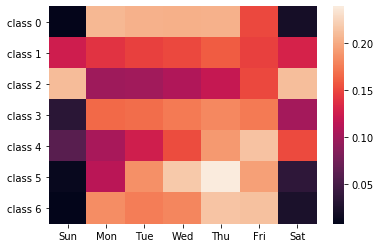

In [243]:
show_kind_of_drivers(7)

**7 classes**
- class 0 (14%): monday to thursday and half of the friday
- class 1 (13%): entire week
- class 2 ( 5%): weekends
- class 3 (20%): monday to friday with partial work on saturday
- class 4 ( 9%): tuesday to saturday with intensity on thursday and friday
- class 5 (14%): tuesday to friday with intensity on wednesday and thursday
- class 6 (25%): monday to friday with intensity on thurday and friday